# <center>${\textbf{Intrusion Detection System}}$</center>


${\textbf{Importing Libraries}}$

In [1]:
import warnings
warnings.simplefilter("ignore")
import pickle
import os
import datetime
from IPython.display import Image

In [2]:
import numpy as np
import pandas as pd
import pandas_profiling as pp

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.metrics import auc,roc_auc_score,confusion_matrix,accuracy_score,classification_report,roc_curve
from sklearn.metrics import mean_squared_error

In [7]:
from sklearn.cluster import KMeans

In [8]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
%load_ext tensorboard

In [9]:
np.random.seed(123)
pd.set_option('display.max_columns', None)
data_path = './data/kddcup.data.corrected'

<center>${\textbf{Data OverView}}$<center> 


In [10]:
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate","label"]
KDD99 =  pd.read_csv(data_path, header=None,names=col_names)

${\textbf{Data Set Information: }}$
This is the data set used for The Third International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-99 The Fifth International Conference on Knowledge Discovery and Data Mining. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between "bad" connections, called intrusions or attacks, and "good" normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment.

Each row of the KDD Cup 99 dataset represents a network connection, with 41 independent variables and 1 dependent variable. The independent variables can be divided into three categories:
1. Basic network connection input characteristics such as duration, protocol type, and number of bytes from source IP addresses
2. Network connection content input features
3. Over a time window, the statistical input features are computed.

${\textbf{Attribute Information: }}$
1. duration: duration of connection in seconds
2. protocoll_type: connection protocol (tcp,udp,icmp)
3. service: dst port mapped to service (http,ftp,...)
4. flag: normal or error status flag of connection
5. src_bytes: number of data bytes from src to dst
6. dst_bytes: number of data bytes from dst to src
7. land: 1 if connection is from/to the same host/port else 0
8. wrong_fragment: number of 'wrong' fragments (0,1,3)
9. urgent: number of urgent packets
10. hot: number of hot indicators(bro-ids feature)
11. num_failed_logins: number of failed login attempts
12. logged_in: 1 if succefully logged in else 0
13. num_compromised: number of compromised condtions
14. root_shell: 1 if root shell obtained else 0
15. su_attempted: 1  if root mood attempted else 0
16. num_root: number of root accesses
17. num_file_creations: number of file creation operations
18. num_shells: number of shell prompts
19. num_access_files:  number of operations on access control files
20. num_outbound_cmds:  number of outbound commands in an ftp session
21. is_host_login:  1 if login belongs to hot list(root,admin) else 0
22. is_guest_login: 1 if login is guest else 0
23. count: number of connections to the same host as current connection in past 2 seconds
24. srv_count: number of connections to the same service as current connection in past 2 seconds
25. serror_rate: % of connections that 'SYN' errors
26. srv_serror_rate:% of connections that gave 'syn' errors in server
27. rerror_rate: % of connection that have 'REJ' errors
28. srv_rerror_rate: % of connection that have 'REJ' errors in server
29. same_srv_rate: % of connection to the same service
30. diff_srv_rate: % of connection to different service
31. srv_diff_host_rate: %of connection to different host
32. dst_host_count: count of connections having same dst host
33. dst_host_srv_count: count of connections having same dst host and using same service
34. dst_host_same_srv_rate: % of connections having same dst host and using same service
35. dst_host_diff_srv_rate: % of differennt service on current host
36. dst_host_same_src_port_rate: % of connections to current host having same src port
37. dst_host_srv_diff_host_rate: % of connections to same service coming from diff hosts
38. dst_host_serror_rate: % of connection the current host that have an S0 error
39. dst_host_srv_serror_rate: %of connections to current host and specified service that have an S0 errot
40. dst_host_rerror_rate: % of connections to current host that have an RST error
41. dst_host_srv_rerror_rate: % of connections to current host and specified service that have and RST error
42. label: connection type

<center>${\textbf{Data Modeling}}$<center>

${\textbf{Autoencoders}}$

We were able to almost perfectly identify the anomalous data in the KDD99 dataset and which type of anomaly occurred. However, in the real-world, labeled data can be expensive and hard to come by. Especially with network security, zero-day attacks can be the most challenging and also the most important attacks to detect. Since, by definition, these attacks are happening for the first time, there will be no way to have labels from them.

So how do we approach this problem?

For starters, we could have security analysts investigate the network packets and label anomalous ones. But that solution doesn't scale and our models might have difficulty identifying attacks that haven't occurred before.

Our solution needs to use "unsupervised learning." Unsupervised learning is the class of machine learning and deep learning algorithms that enable us to draw inferences from our dataset without labels.

In this lab we will use autoencoders (AEs) to detect anomalies in the KDD99 dataset. There are a lot of advantages to using autoencoders for detecting anomalies. One main advantage is the that AEs can learn non-linear relationships in the data.

While we will not be using the labels in the KDD99 dataset explicitly for model training, we will be using them to evaluate how well our model is doing at detecting the anomalies. We will also use the labels to see if the AE is embedding the anomalies in latent space according to the type of anomaly.

Recall that when using XGBoost, the ratio didn't impact training meaningfully. Anomalies were simply a class of our dataset, not made special in any way by their rare nature. Using AutoEncoders, you'll see that that's no longer true. We'll explore the questions of how rare is rare enough? and how does that impact our ability to identify multiple classes of anomalies?.

In [14]:
def reduce_anomalies(df, pct_anomalies=.01):
    labels = df['label'].copy()
    is_anomaly = labels != 'normal.'
    num_normal = np.sum(~is_anomaly)
    num_anomalies = int(pct_anomalies * num_normal)
    all_anomalies = labels[labels != 'normal.']
    anomalies_to_keep = np.random.choice(all_anomalies.index, size=num_anomalies, replace=False)
    anomalous_data = df.iloc[anomalies_to_keep].copy()
    normal_data = df[~is_anomaly].copy()
    new_df = pd.concat([normal_data, anomalous_data], axis=0)
    return new_df
pct_anomalies = .01
kDD = reduce_anomalies(KDD99, pct_anomalies=pct_anomalies)

In [15]:
filename = './data/preprocessed_data_full.pkl'
input_file = open(filename,'rb')
preprocessed_data = pickle.load(input_file)
input_file.close()

In [16]:
le = preprocessed_data['le']
x_train = preprocessed_data['x_train']
y_train = preprocessed_data['y_train']
x_test = preprocessed_data['x_test']
y_test = preprocessed_data['y_test']

In [17]:
# capture the categorical variables and one-hot encode them
cat_vars = ['protocol_type', 'service', 'flag', 'land', 'logged_in','is_host_login', 'is_guest_login']

# find unique labels for each category
cat_data = pd.get_dummies(kDD[cat_vars])

numeric_vars = list(set(kDD.columns.values.tolist()) - set(cat_vars))
numeric_vars.remove('label')
numeric_data = kDD[numeric_vars].copy()

numeric_cat_data = pd.concat([numeric_data, cat_data], axis=1)

# capture the labels
labels = kDD['label'].copy()

# convert labels to integers
integer_labels = le.transform(labels)

# split data into test and train
x_train, x_test, y_train, y_test = train_test_split(numeric_cat_data,
                                                    integer_labels,
                                                    test_size=.25, 
                                                    random_state=42)

In [18]:
# Normalize the testing and training data using the MinMaxScaler from the scikit learn package
scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# convert the data to FP32
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

Autoencoders are a subset of neural network architectures where the output dimension is the same as the input dimension. Autoencoders have two networks, an encoder and a decoder. The encoder encodes its input data into a smaller dimensional space, called the latent space. The decoder network tries to reconstruct the original data from the latent encoding. Typically, the encoder and decoder are symmetric, and the latent space is a bottleneck. The autoencoder has to learn essential characteristics of the data to be able to do a high-quality reconstruction of the data during decode.

- batch_size: this determines how many datapoints we use for each gradient update. Choosing a large batch size will make the model train faster but it might not result in the best accuracy or generalization.

- latent_dim: this determines the size of our bottleneck. Higher values add network capacity while lower values increase the efficiency of the encoding.

- max_epochs: should be high enough for the network to learn from the data, but not so high as to overfit the training data or diverge to a worse result

In [19]:
input_dim = x_train.shape[1]

# model hyperparameters
batch_size = 512

latent_dim = 4 

max_epochs = 10 

In [20]:
# The encoder will consist of a number of dense layers that decrease in size 
# as we taper down towards the bottleneck of the network, the latent space
input_data = Input(shape=(input_dim,), name='encoder_input')

# hidden layers
encoder = Dense(96,activation='tanh', name='encoder_1')(input_data)
encoder = Dropout(.1)(encoder)
encoder = Dense(64,activation='tanh', name='encoder_2')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(48,activation='tanh', name='encoder_3')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(16,activation='tanh', name='encoder_4')(encoder)
encoder = Dropout(.1)(encoder)

# bottleneck layer
latent_encoding = Dense(latent_dim, activation='linear', name='latent_encoding')(encoder)

In [21]:
encoder_model = Model(input_data, latent_encoding)

encoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 114)]             0         
                                                                 
 encoder_1 (Dense)           (None, 96)                11040     
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 encoder_2 (Dense)           (None, 64)                6208      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 encoder_3 (Dense)           (None, 48)                3120      
                                                                 
 dropout_2 (Dropout)         (None, 48)                0     

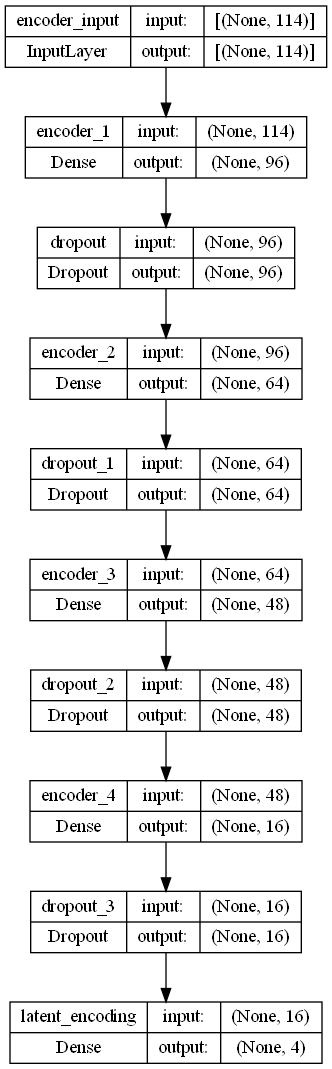

In [22]:
plot_model(
    encoder_model, 
    to_file='encoder_model.png', 
    show_shapes=True, 
    show_layer_names=True, 
    rankdir='TB' # TB for top to bottom, LR for left to right
)
Image(filename='encoder_model.png')

In [23]:
# The decoder network is a mirror image of the encoder network
decoder = Dense(16, activation='tanh', name='decoder_1')(latent_encoding)
decoder = Dropout(.1)(decoder)
decoder = Dense(48, activation='tanh', name='decoder_2')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(64, activation='tanh', name='decoder_3')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(96, activation='tanh', name='decoder_4')(decoder)
decoder = Dropout(.1)(decoder)

# The output is the same dimension as the input data we are reconstructing
reconstructed_data = Dense(input_dim, activation='linear', name='reconstructed_data')(decoder)

In [24]:
autoencoder_model = Model(input_data, reconstructed_data)

autoencoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 114)]             0         
                                                                 
 encoder_1 (Dense)           (None, 96)                11040     
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 encoder_2 (Dense)           (None, 64)                6208      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 encoder_3 (Dense)           (None, 48)                3120      
                                                                 
 dropout_2 (Dropout)         (None, 48)                0   

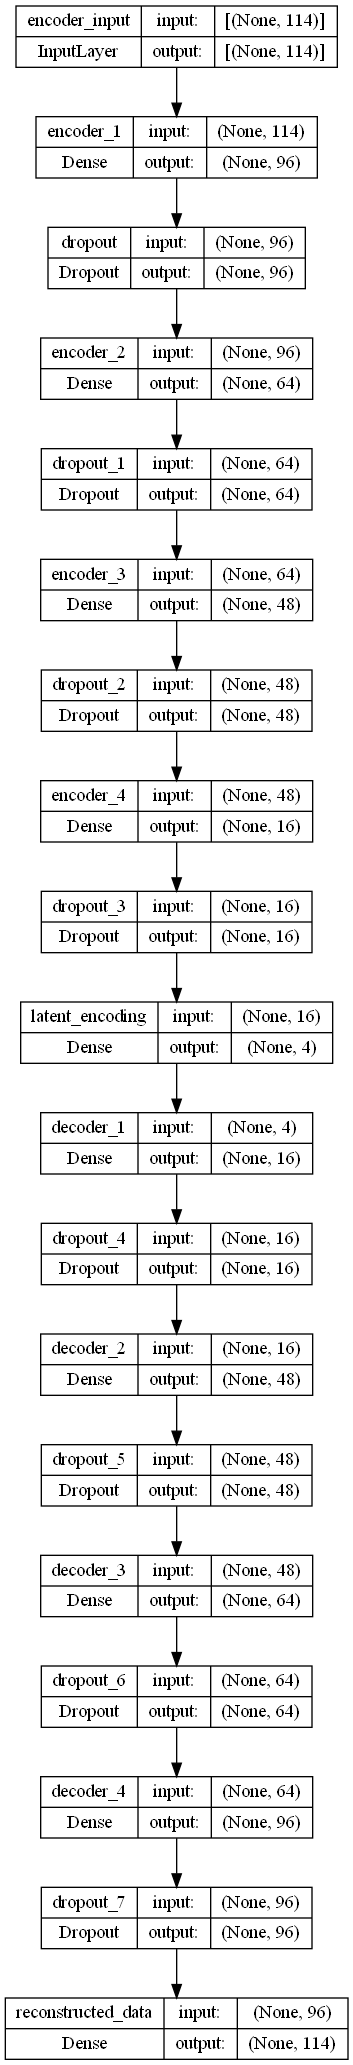

In [25]:
plot_model(
    autoencoder_model, 
    to_file='autoencoder_model.png', 
    show_shapes=True, 
    show_layer_names=True, 
    rankdir='TB' # TB for top to bottom, LR for left to right
)

Image(filename='autoencoder_model.png')

In [26]:
opt = optimizers.Adam(lr=.00001)

autoencoder_model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

In [27]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,profile_batch=0,update_freq='epoch',histogram_freq=1)

train_history = autoencoder_model.fit(x_train, x_train,
        shuffle=True,
        epochs=max_epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[tensorboard_callback])

Epoch 1/10
1440/1440 [==============================] - 11s 6ms/step - loss: 0.0523 - accuracy: 0.0423 - val_loss: 0.0172 - val_accuracy: 0.0359
Epoch 2/10
1440/1440 [==============================] - 7s 5ms/step - loss: 0.0247 - accuracy: 0.0810 - val_loss: 0.0114 - val_accuracy: 0.1365
Epoch 3/10
1440/1440 [==============================] - 8s 5ms/step - loss: 0.0175 - accuracy: 0.1046 - val_loss: 0.0084 - val_accuracy: 0.0821
Epoch 4/10
1440/1440 [==============================] - 7s 5ms/step - loss: 0.0132 - accuracy: 0.1150 - val_loss: 0.0068 - val_accuracy: 0.1591
Epoch 5/10
1440/1440 [==============================] - 8s 5ms/step - loss: 0.0108 - accuracy: 0.1334 - val_loss: 0.0061 - val_accuracy: 0.1892
Epoch 6/10
1440/1440 [==============================] - 7s 5ms/step - loss: 0.0094 - accuracy: 0.1457 - val_loss: 0.0056 - val_accuracy: 0.1606
Epoch 7/10
1440/1440 [==============================] - 7s 5ms/step - loss: 0.0085 - accuracy: 0.1613 - val_loss: 0.0054 - val_accuracy

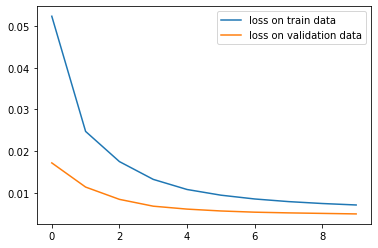

In [28]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['loss on train data', 'loss on validation data'])

In [29]:
%tensorboard --logdir logs

In [30]:
# Reconstruct the data using our trainined autoencoder model.
x_test_recon = autoencoder_model.predict(x_test)

# the reconstruction score is the mean of the reconstruction errors (relatively high scores are anomalous)
reconstruction_scores = np.mean((x_test - x_test_recon)**2, axis=1)

7676/7676 [==============================] - 9s 1ms/step


In [31]:
# store the reconstruction data in a Pandas dataframe
anomaly_data = pd.DataFrame({'recon_score':reconstruction_scores})

# if our reconstruction scores our normally distributed we can use their statistics
anomaly_data.describe()

,recon_score
count,245627.000000
mean,0.004943
std,0.008051
min,0.000067
25%,0.000517
50%,0.001984
75%,0.006877
max,1.458756


<AxesSubplot:xlabel='Reconstruction Score', ylabel='Frequency'>

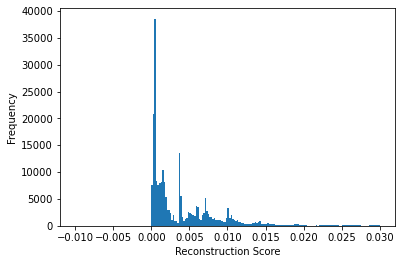

In [32]:
# plotting the density will give us an idea of how the reconstruction scores are distributed
plt.xlabel('Reconstruction Score')
anomaly_data['recon_score'].plot.hist(bins=200, range=[-.01, .03])

In [33]:
def convert_label_to_binary(label_encoder, labels):
    normal_idx = np.where(label_encoder.classes_ == 'normal.')[0][0]
    my_labels = labels.copy()
    my_labels[my_labels != normal_idx] = 1 
    my_labels[my_labels == normal_idx] = 0
    return my_labels

In [34]:
# convert our labels to binary
binary_labels = convert_label_to_binary(le, y_test)

# add the binary labels to our anomaly dataframe
anomaly_data['binary_labels'] = binary_labels

# let's check if the reconstruction statistics are different for labeled anomalies
anomaly_data.groupby(by='binary_labels').describe()

recon_score                                                    \
                    count      mean       std       min       25%       50%   
binary_labels                                                                 
0                243161.0  0.004459  0.006350  0.000067  0.000508  0.001921   
1                  2466.0  0.052666  0.013372  0.001214  0.046436  0.046436   

                                   
                    75%       max  
binary_labels                      
0              0.006682  1.458756  
1              0.046436  0.079201

We can see from the above that the anomalous data has a mean reconstruction score of 0.05 while the normal data has a score of ~0.004. This is a good sign that our autoencoder has learned to reconstruct normal data but fails to reconstruct anomalous data.

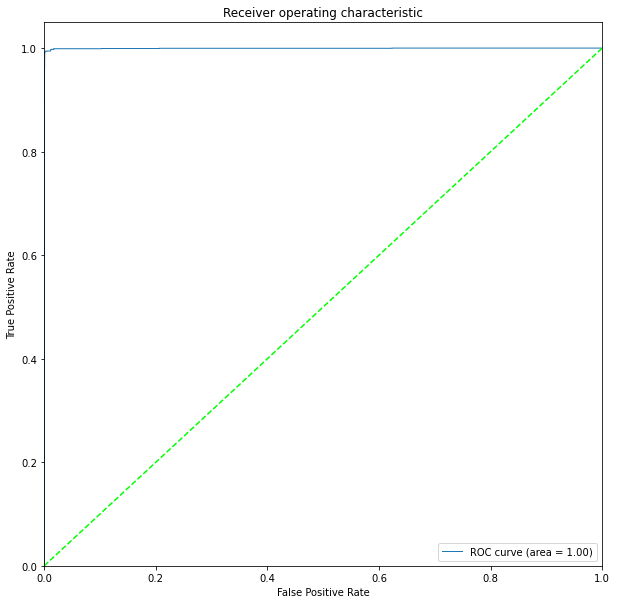

In [35]:
fpr, tpr, thresholds = roc_curve(binary_labels, reconstruction_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='lime', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

The ROC Curve looks great and we have a perfect AUC score. This is a good sign, but we still need to verify that we can set a threshold which accomplishes our business objective. In this lab we are looking to detect as many anomalies as possible while also minimizing the number of false positives.

In [37]:
# We can pick the threshold based on maximizing the true positive rate (tpr) 
# and minimizing the false positive rate (fpr)
optimal_threshold_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_idx]
print(optimal_threshold)

0.035075925


In [38]:
# Or we assume our reconstructions are normally distributed and label anomalies as those
# that are a number of standard deviations away from the mean
recon_mean = np.mean(reconstruction_scores)
recon_stddev = np.std(reconstruction_scores)
stats_threshold = recon_mean + 5*recon_stddev
print(stats_threshold)

0.04519888898357749


In [41]:
#thresh = optimal_threshold
thresh = stats_threshold
print(thresh)
pred_labels = (reconstruction_scores > thresh).astype(int)
results = confusion_matrix(binary_labels, pred_labels) 

0.04519888898357749


Confusion Matrix: 


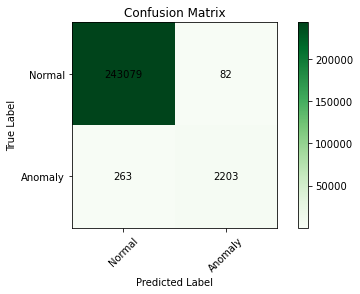

In [42]:
print ('Confusion Matrix: ')

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


plot_confusion_matrix(results, ['Normal','Anomaly'])

Analyzing the confusion matrix, we see that we get optimal results. The algorithm is labeling most of the normal data anomalous data correctly while mislabeling very infrequently.

In [43]:
# subset the test data so that we are only looking at the predicted anomalies
x_test_df = pd.DataFrame(x_test)

test_anomalies = x_test_df[pred_labels.astype('bool')]

y_test_df = pd.DataFrame(y_test)
test_anomalies_labels = y_test_df[pred_labels.astype('bool')]

# encode the test anomalies into latent space
encoded_test_anomalies = encoder_model.predict(test_anomalies)

72/72 [==============================] - 0s 831us/step


In [44]:
# apply KMeans to the data in order to create clusters of anomalies
kmeans = KMeans(n_clusters=10, random_state=123)
kmeans.fit(encoded_test_anomalies)

KMeans(n_clusters=10, random_state=123)

In [45]:
clusters = pd.DataFrame({'cluster':kmeans.labels_, 'label':test_anomalies_labels[0]})

most_frequent_labels = clusters.groupby('cluster').label.value_counts()

print(most_frequent_labels)

cluster  label
0        9           4
         11          2
         15          2
         17          2
1        18       1633
2        9          26
         11          4
3        9         536
4        11         15
5        11         18
6        11         11
7        11         12
8        11         11
9        11          9
Name: label, dtype: int64


In [46]:
# this dictionary will map our cluster values to the labels that appear most frequently
cluster_to_label = {}
for cluster in range(0, 10):
    label = most_frequent_labels[cluster].index[0]
    cluster_to_label[cluster] = label

# we then replace the clusters inplace by their label values
clusters.cluster.replace(cluster_to_label, inplace=True)

Confusion Matrix :


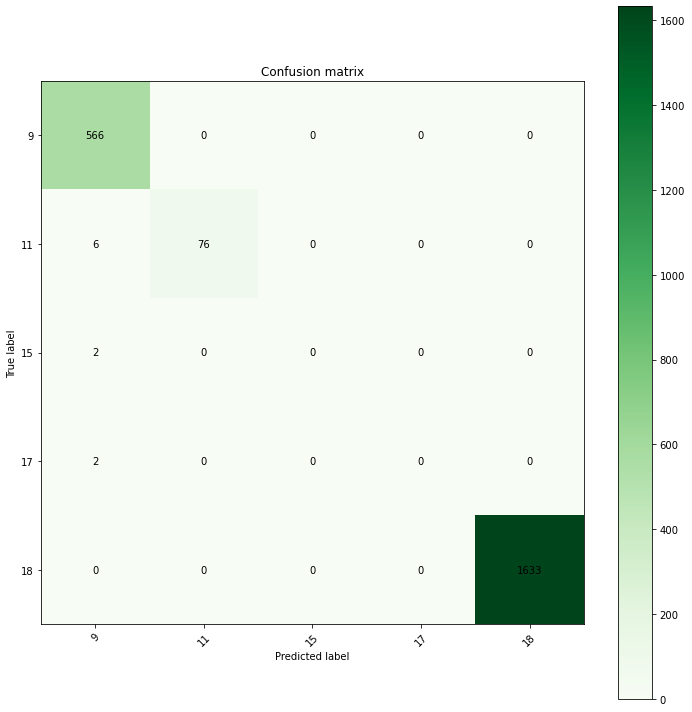

In [47]:
target_names = np.unique(list(clusters.label))
cm = confusion_matrix(clusters.label, clusters.cluster)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm,target_names, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm,target_names)

- We were successfully able to detect KDD99 anomalies without using the labels for training by using a deep autoencoder.
- We then showed that autoencoder model was embedding the anomalous datapoints in latent space according to the type of anomaly.
- This means we could begin labeling the anomalous data by having SMEs look at a small fraction of the total data.